# Convergence check on the basis set
This exercise follows the same steps that are explained in the lesson on a [methane molecule](https://l_sim.gitlab.io/bigdft-suite/tutorials/CH4.html).

The purpose of this lesson is to get familiar with the basic variables needed to run a wavelet computation in isolated boundary conditions.
Here we start from a different system, which will be also employed in comparing the results of BigDFT with gaussian basis set calculations.

In [1]:
from BigDFT.Database.Molecules import get_molecule
sys=get_molecule('CH3SH')

In [3]:
sys.display()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [4]:
from BigDFT.IO import XYZReader
from BigDFT.Systems import System
from BigDFT.Fragments import Fragment

geom = "CH3SH"

sys = System()
sys["FRA:0"] = Fragment()
sys["FRA:1"] = Fragment()

with XYZReader(geom) as ifile:
    for i, at in enumerate(ifile):
        if i == 0 or i == 3 or i == 4 or i == 5:
            sys["FRA:0"] += Fragment([at])
        else:
            sys["FRA:1"] += Fragment([at])

In [5]:
sys.display()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## The wavelet basis set, a convergence study

Daubechies Wavelets is a systematic basis set (as plane waves are), which means than one can increase arbitrarily the accuracy of the results by varying some parameters which are defined in the `dft` dictionary (`inp['dft']`).
We here explain what are the meaning and the typical values for the principal parameters, `hgrid` and `rmult`.

**`hgrids`**
      are used to set up the basis set. In free boundary conditions, the basis set is characterised
      by a spatial expansion and a grid step, as shown in the side figure.
      There is ''one float value'' describing the ''grid steps'' in the three space directions (''i.e.'' x, y and z)
      or a 3D array is also accepted.
      These values are in bohr unit and typically range from 0.3 to 0.65. The
      harder the pseudo-potential, the lower value should be set up.
      These values are called `hgrids` in the input dictionary, and can be set by the `set_hgrid` method of the 
      `Inpufile` class.
        
**`rmult`**
      contains an array of two float values that are two multiplying factors.
      They multiply quantities that are chemical species dependent.
      The first factor is the most important since it
      describes ''the spatial expansion'' of the basis set (in yellow on the figure beside).
      Indeed the basis set is defined as a set of real space points with non-zero values.
      These points are on a global regular mesh and located inside spheres centered on atoms.
      The first multiplying factor is called `crmult` for Coarse grid Radius MULTiplier.
      Increasing it means that further spatial expansion is possible for the wavefunctions. 
      Typical values are 5 to 7.
      The second one called `frmult` for Fine grid Radius MULTiplier is related to the fine resolution.
      This parameter is less pertinent for the convergence of energy and can be ignored.
      It is possible to indicate only one float value, the `crmult` parameter.
      Such parameters can be set by the method `set_rmult` of `Inputfile` class.
      
### Objective

Let us run BigDFT for the following values of *hgrid* and *crmult* and plot the total energy convergence versus `hgrids`. 
The final total energy can be retrieved using the method `energy` from the result of each of the runs. The unit of the energies is in Hartree. 

In [6]:
hgrids = [0.55, 0.5, 0.45, 0.4, 0.35, 0.3] #bohr
crmult = [4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0]

In [7]:
from BigDFT.Inputfiles import Inputfile
inp = Inputfile()
inp.set_xc("LDA")


In [8]:
from BigDFT.Calculators import SystemCalculator
code = SystemCalculator(verbose=False, skip=True)

In [9]:
from numpy import array

bigdft_energies = {}
bigdft_forces = {}
for h in hgrids:
    print(h)
    inp.set_hgrid(h)
    bigdft_energies[h] = []
    bigdft_forces[h] = []
    for c in crmult:
        inp.set_rmult([c,9.0])
        log = code.run(input=inp, posinp=sys.get_posinp(), 
                       name='LDA-'+str(h) + "-" + str(c), run_dir="work")
        sys.set_atom_forces(log)
        bigdft_energies[h].append(log.energy)
        
        forces = []
        for frag in sys.values():
            for at in frag:
                forces.append(at.get_force())
        bigdft_forces[h].append(array(forces))

0.55
0.5
0.45
0.4
0.35
0.3


After the calculation have been issued, we can analyze the variation of the energy with respect to the best parameter.

In [ ]:
hx,cy,ez=3*[[]]
for i,(h, de) in enumerate(bigdft_energies.items()):
    for c, e in zip(crmult,de):
        hx[i].append

/tmp/ipykernel_30918/4292393508.py:8: RuntimeWarning: divide by zero encountered in log
  LogE=numpy.log(E-E.min())


Text(0.5, 0.92, '$Log (E-E_{min})$')

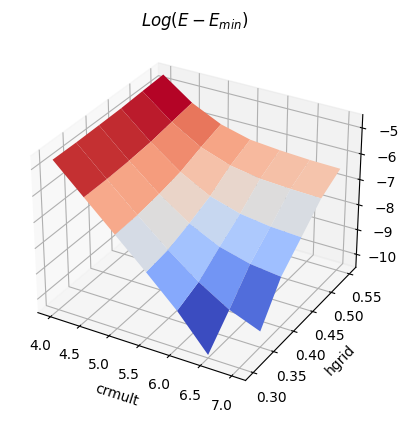

In [11]:
from matplotlib import pyplot as plt
from matplotlib.colors import LightSource
from matplotlib import cm
import numpy 
X=len(hgrids)*[crmult]
Y=numpy.array([hgrids]*len(crmult)).T
E=numpy.array([bigdft_energies[h] for h in hgrids])
LogE=numpy.log(E-E.min())
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
ls = LightSource(4, 0.4)
# To use a custom hillshading mode, override the built-in shading and pass
# in the rgb colors of the shaded surface calculated from "shade".
rgb = ls.shade(LogE, cmap=cm.gist_earth, vert_exag=0.1, blend_mode='soft')
ax.plot_surface(X,Y,LogE,cmap=cm.coolwarm)
ax.set_ylabel('hgrid')
ax.set_xlabel('crmult')
ax.set_title(r'$Log (E-E_{min})$')

This set of calculations would show the way in which the basis set approaches the systematic result.